In [195]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import csv
import random

rc("font", **{"family": "Times"})
rc("text", usetex=True)

plt.rcParams['figure.dpi']= 300

In [196]:
# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')

def moving_average(interval, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(interval, window, 'valid')

def plot_profitability(trial_id):
    prices_fname = trial_id + '_strats.csv'
    times_list = []
    buyer_pss_list = []
    seller_pps_list = []
    total_pps_list = []
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = int(row[1])
            # print(row)
            buyer_pps = 0
            seller_pps = 0
            for i in range(2, len(row) - 13, 7):
                if row[i + 1][0] == 'B':
                    buyer_pps += float(row[i + 6])
                elif row[i + 1][0] == 'S':
                    seller_pps += float(row[i + 6])
            times_list.append(time / 60 / 60 / 24)
            buyer_pss_list.append(buyer_pps)
            seller_pps_list.append(seller_pps)
            total_pps_list.append(buyer_pps + seller_pps)
    print("Average PPS:", np.mean(total_pps_list))
    print("Standard Deviation PPS:", np.std(total_pps_list))
    plt.figure(figsize=(5, 3))
    plt.scatter(times_list, buyer_pss_list, marker = 'x', s = 0.01)
    plt.scatter(times_list, seller_pps_list, marker = 'x', s = 0.01)
    plt.scatter(times_list, total_pps_list, marker = 'x', s = 0.01)
    ma_length = 24 * 7
    start = ma_length // 2 - 1
    end = -1 * start - 1
    plt.plot(times_list[start:end], moving_average(buyer_pss_list, ma_length), label = "$\pi_B$")
    plt.plot(times_list[start:end], moving_average(seller_pps_list, ma_length), label = "$\pi_S$")
    plt.plot(times_list[start:end], moving_average(total_pps_list, ma_length), label = "$\pi_T$")
    plt.xlim(0, times_list[-1])
    plt.ylim(0, 200)
    plt.minorticks_on()
    plt.grid(linestyle=":")
    plt.ylabel("Profit per Second")
    plt.xlabel("Day")
    plt.legend()
    plt.savefig(f"figures/{trial_id}_pps.png", bbox_inches='tight', pad_inches=0.02)
    plt.show()

def plot_strats(trial_id):
    bins = np.arange(-1, 1, 0.05)
    prices_fname = trial_id + '_strats.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        time = 0
        bs_all = np.array([], dtype = np.uint).reshape(0, 15)
        ss_all = np.array([], dtype = np.uint).reshape(0, 15)
        for row in reader:
            time = int(row[1])
            bs = []
            ss = []
            for i in range(2, len(row) - 13, 7):
                if row[i + 1][0] == 'B':
                    bs.append(float(row[i + 4]))
                elif row[i + 1][0] == 'S':
                    ss.append(float((row[i + 4])))
            bs_binned = np.digitize(bs, bins) - 1
            ss_binned = np.digitize(ss, bins) - 1
            bs_all = np.vstack([bs_all, bs_binned])
            ss_all = np.vstack([ss_all, ss_binned])

    bs_all = bs_all.astype(int)
    ss_all = ss_all.astype(int)
    bs_all_counts = np.array([]).reshape(0, 40)
    ss_all_counts = np.array([]).reshape(0, 40)
    for i in range(bs_all.shape[0]):
        bs_counts = np.bincount(bs_all[i], minlength = 40)
        ss_counts = np.bincount(ss_all[i], minlength = 40)
        bs_all_counts = np.vstack([bs_all_counts, bs_counts])
        ss_all_counts = np.vstack([ss_all_counts, ss_counts])

    print("Buyer Strats")
    plt.figure(figsize=(5, 3))
    cmap = plt.get_cmap('Reds', np.max(bs_all_counts) - np.min(bs_all_counts) + 1)
    mat = plt.matshow(
        bs_all_counts.T, 
        cmap = cmap,
        fignum = 1, 
        aspect = 'auto', 
        origin = 'lower',
        extent = [0, time / 60 / 60 / 24, -1, 1],
        vmin = np.min(bs_all_counts) - 0.5,
        vmax = np.max(bs_all_counts) + 0.5
    )
    plt.ylabel("$s$-value")
    plt.xlabel("Day")
    plt.minorticks_on()
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.colorbar(mat, ticks = np.arange(np.min(bs_all_counts), np.max(bs_all_counts) + 1))
    plt.savefig(f"figures/{trial_id}_buy_strats.png", bbox_inches='tight', pad_inches=0.0)
    plt.show()

    print("Seller Strats")
    plt.figure(figsize=(5, 3))
    cmap = plt.get_cmap('Reds', np.max(ss_all_counts) - np.min(ss_all_counts) + 1)
    mat = plt.matshow(
        ss_all_counts.T, 
        cmap = cmap, 
        fignum = 1, 
        aspect = 'auto', 
        origin = 'lower', 
        extent = [0, time / 60 / 60 / 24, -1, 1],
        vmin = np.min(ss_all_counts) - 0.5,
        vmax = np.max(ss_all_counts) + 0.5
    )
    plt.ylabel("$s$-value")
    plt.xlabel("Day")
    plt.minorticks_on()
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.colorbar(mat, ticks = np.arange(np.min(ss_all_counts), np.max(ss_all_counts) + 1))
    plt.savefig(f"figures/{trial_id}_sell_strats.png", bbox_inches='tight', pad_inches=0.0)
    plt.show()

k=4,F=0.0
Average PPS: 154.31342065458333
Standard Deviation PPS: 12.967221600355796


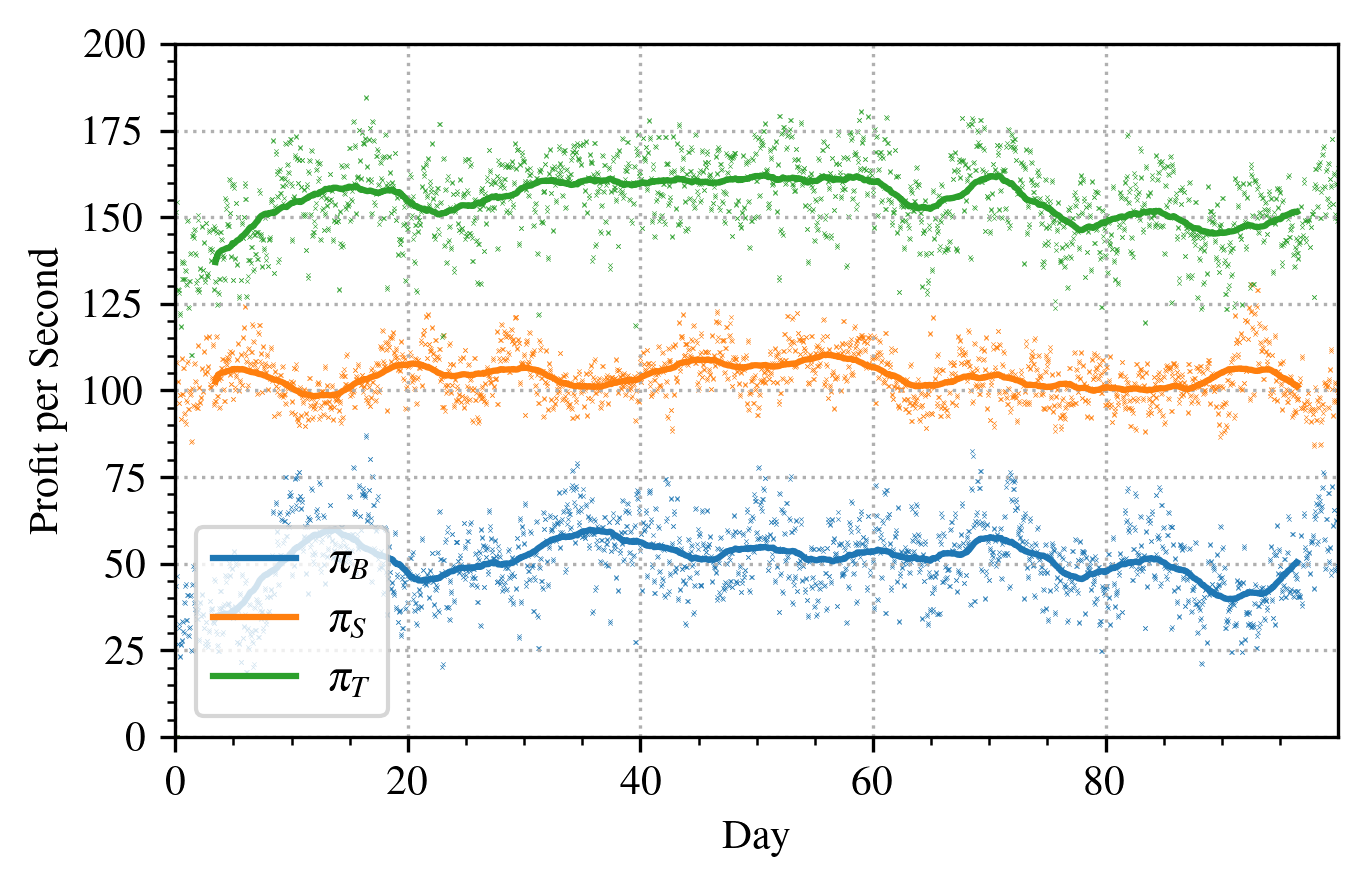

k=4,F=0.4
Average PPS: 161.87401816958334
Standard Deviation PPS: 15.13913604605875


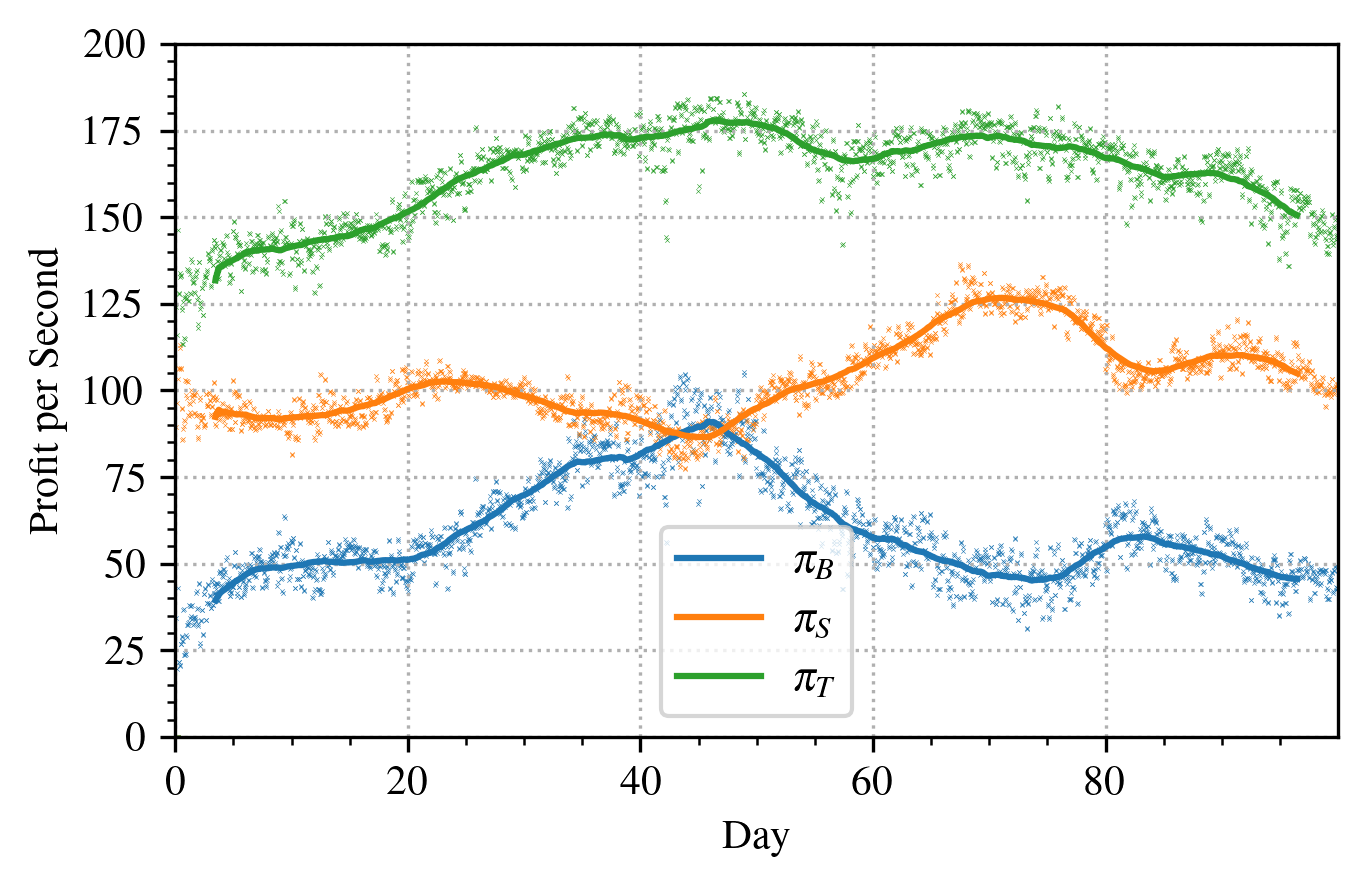

k=4,F=0.6
Average PPS: 164.80347312916666
Standard Deviation PPS: 13.378083058551487


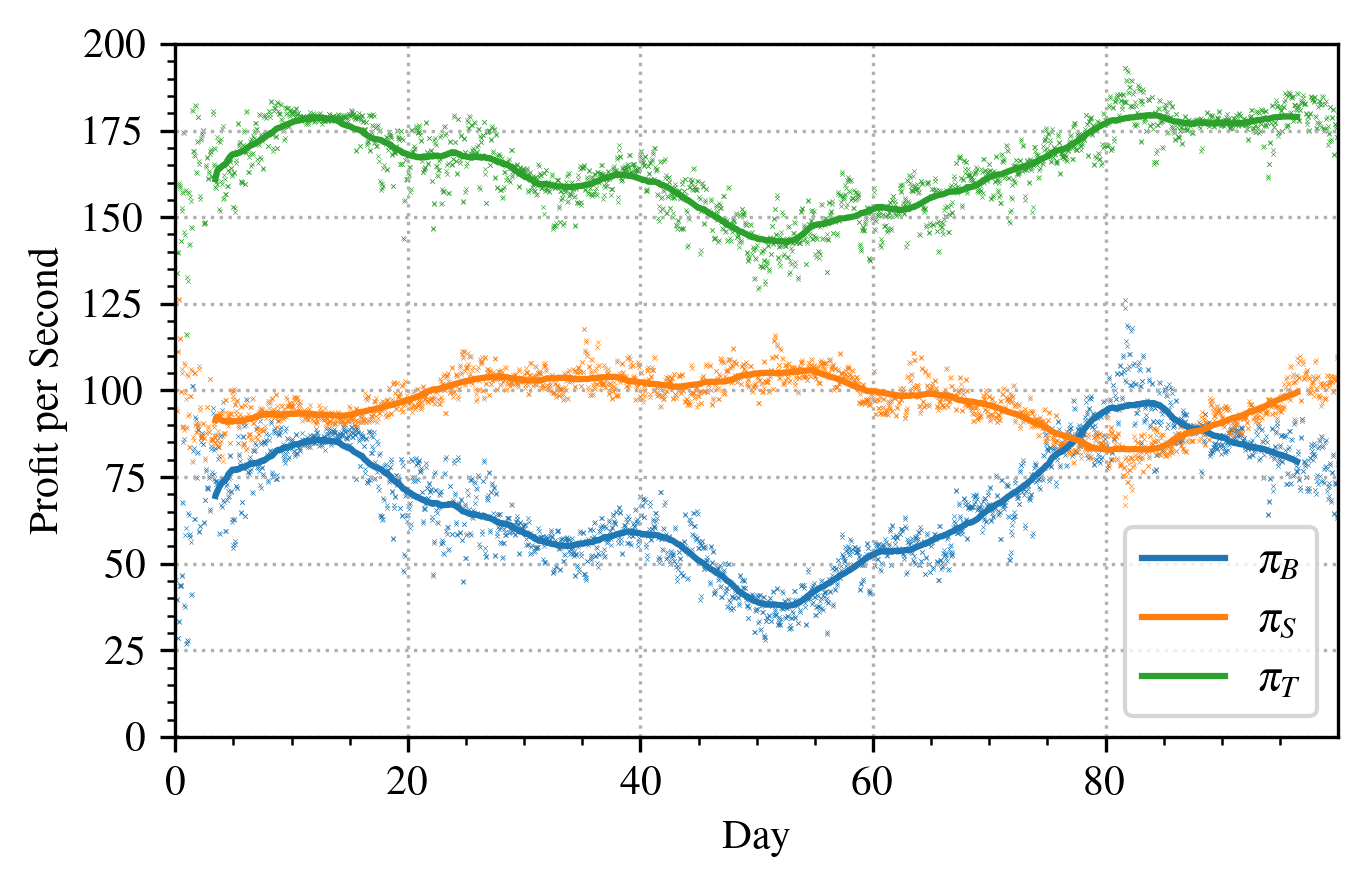

k=4,F=0.8
Average PPS: 176.55677544333335
Standard Deviation PPS: 11.639652336522406


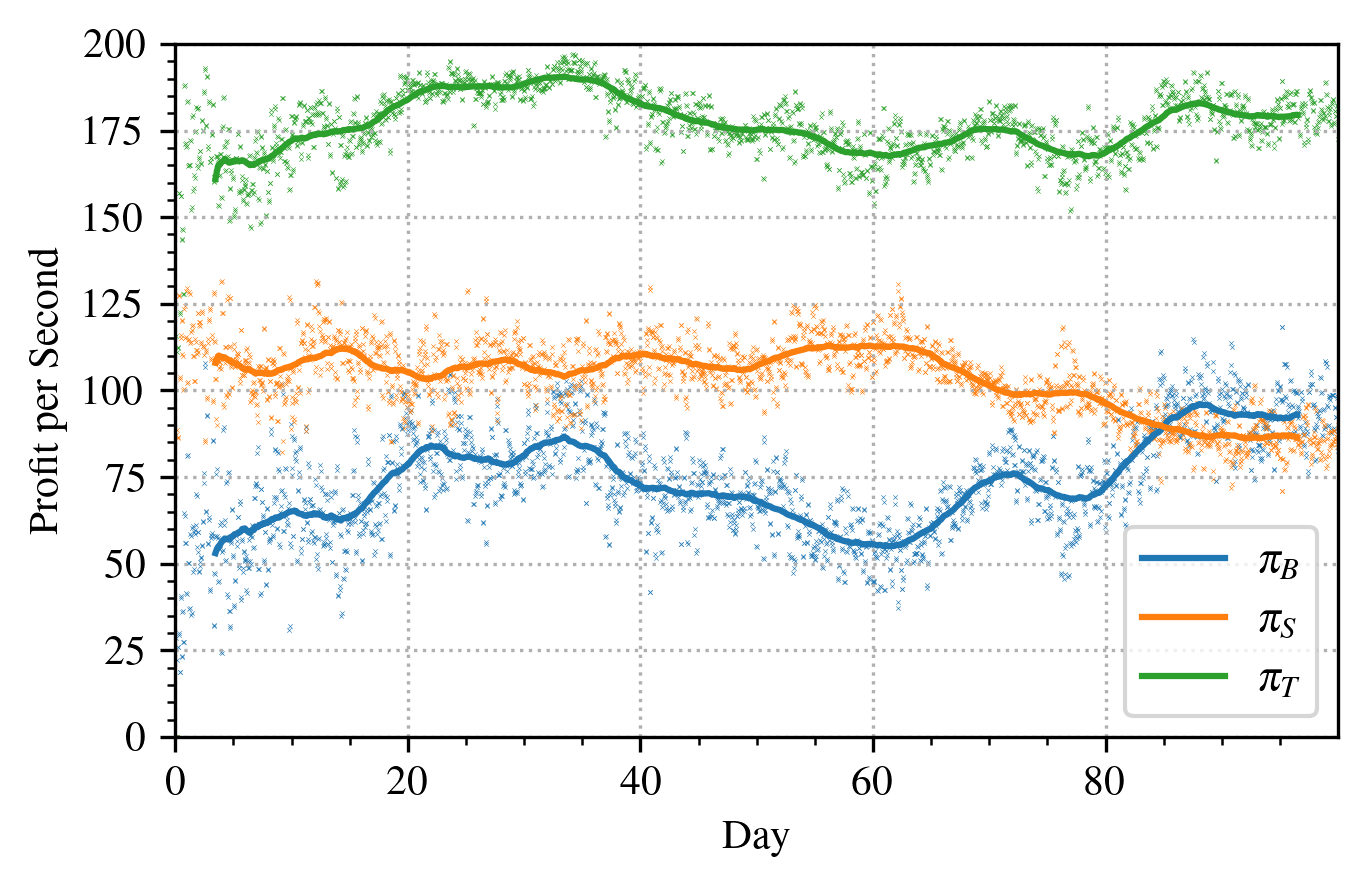

k=4,F=1.0
Average PPS: 169.47689920854273
Standard Deviation PPS: 14.659760809466608


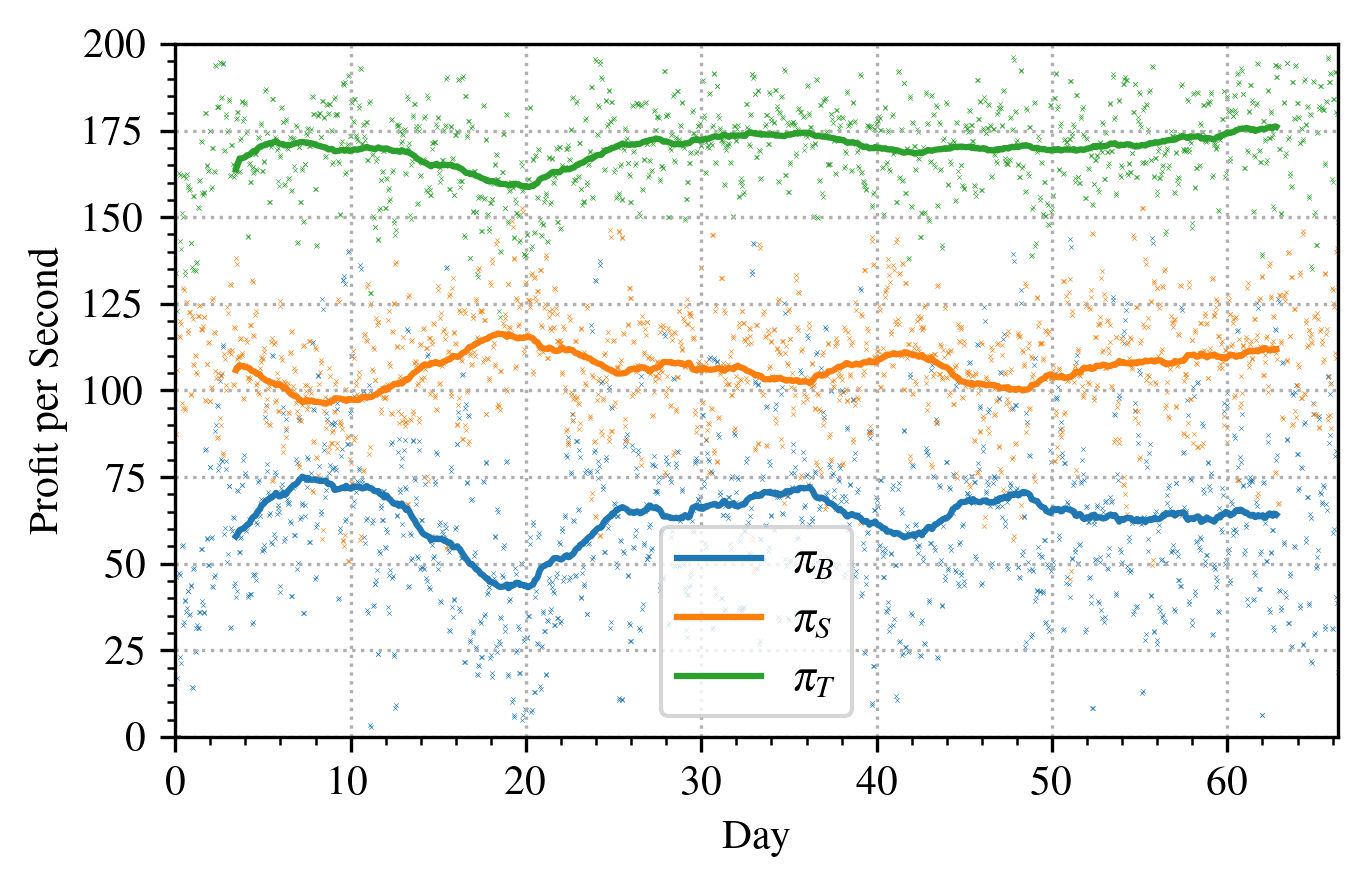

k=4,F=1.2
Average PPS: 169.12092775208333
Standard Deviation PPS: 13.983162240123313


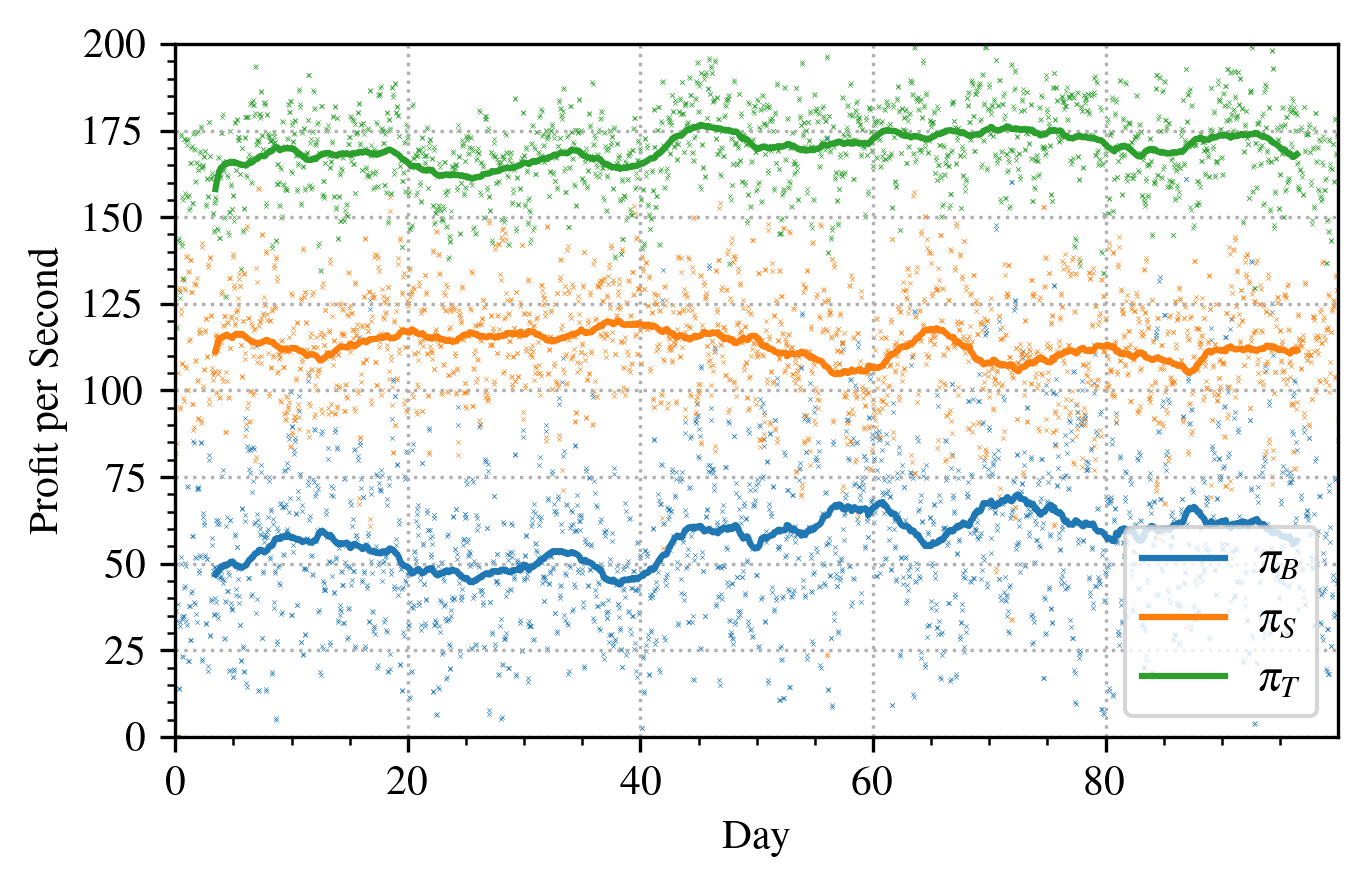

k=4,F=1.6
Average PPS: 170.85029267583334
Standard Deviation PPS: 13.015230818358644


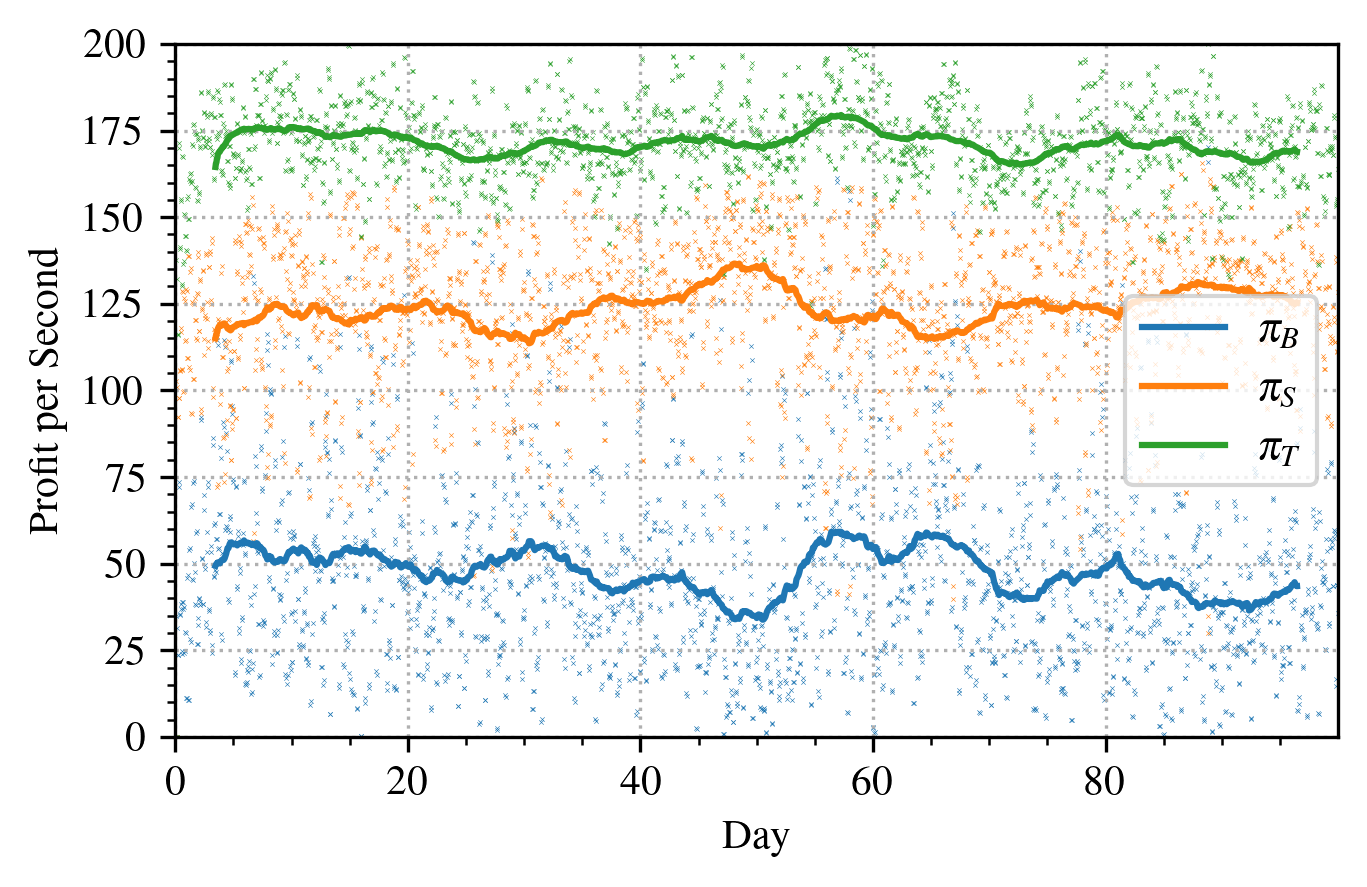

k=4,F=2.0
Average PPS: 171.29248941083333
Standard Deviation PPS: 12.416175025043048


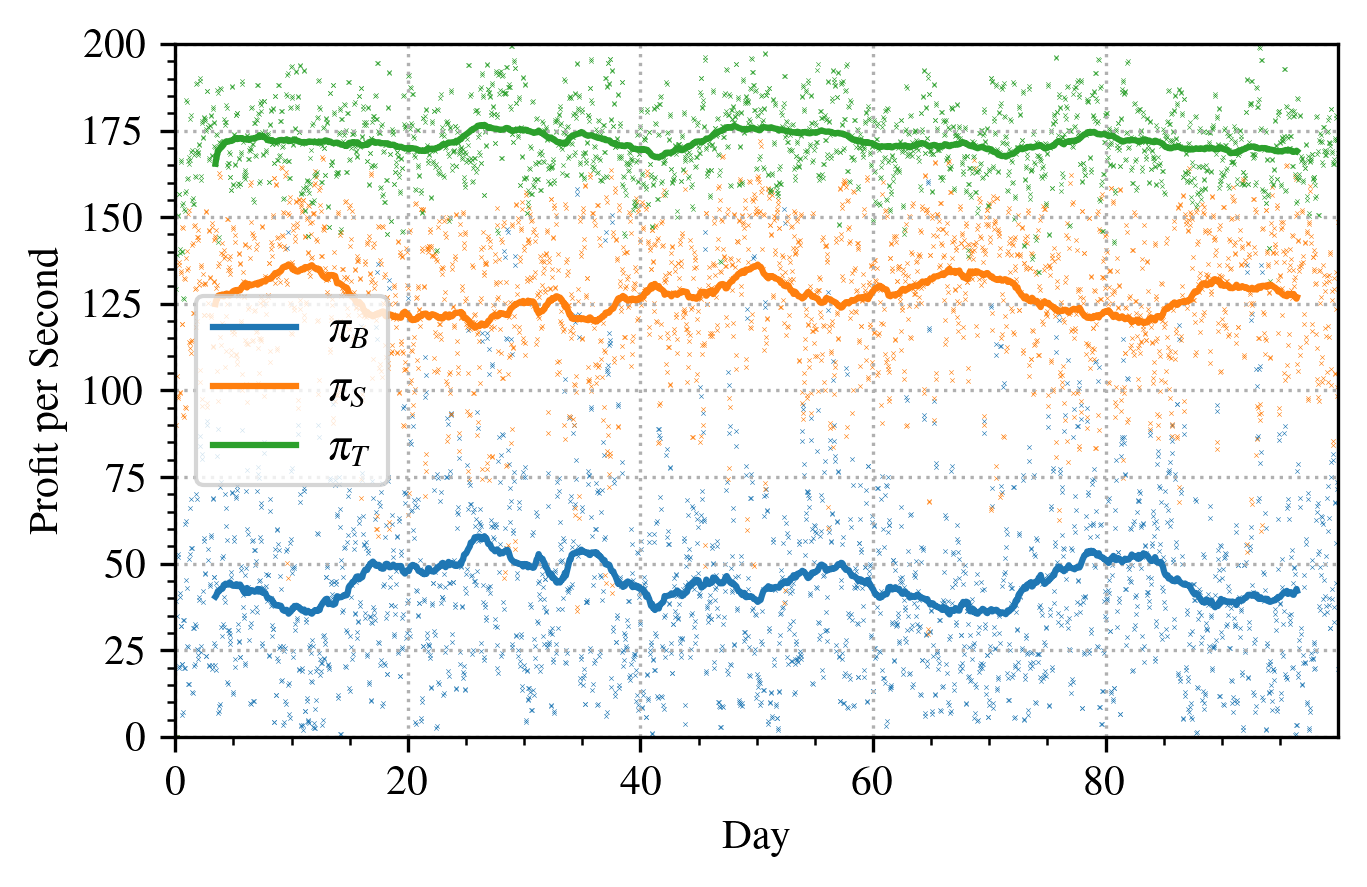

In [197]:
f = 0.8
k = 4

# for k in [4, 8, 16, 32, 64]:
#     print(trial_id := f"k={k},F={f}")
#     plot_profitability(trial_id)
    # plot_strats(trial_id)

for f in [0.0, 0.4, 0.6, 0.8, 1.0, 1.2, 1.6, 2.0]:
    f = round(f, 2)
    print(trial_id := f"k={k},F={f}")
    plot_profitability(trial_id)
    # plot_strats(trial_id)